In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from omegaconf import OmegaConf

In [2]:
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import os

In [29]:
# Good params on cart-pole from proprio
# DIR = "/home/ira/code/projects/rl_trickery/multirun/0_saved_experiments/long_ff_cart/"

# maze



# DIR = "/home/ira/code/projects/rl_trickery/multirun/0_saved_experiments/crnn_new_maze_11/"

# DIR = "/home/ira/code/projects/rl_trickery/multirun/2020-06-16/20-38-12//"


In [75]:
# maze runs


# maze11
# random recurse depth
DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/maze11-ff-rand-recurse/"
# DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/maze11-rnn-rand-recurse/"
# DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/maze11-crnn-rand-recurse/"



In [76]:
runs = os.listdir(DIR)
runs = sorted([int(run) for run in runs if "." not in run])
runs = list(map(str, runs))
runs

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [77]:
dfs = {}
overrides = {}
configs = {}
for run in runs:
    f_eval = DIR + run + "/eval.csv"
    f_train = DIR + run + "/train.csv"    
    f_config = DIR + run + "/.hydra/config.yaml"    
    f_override = DIR + run + "/.hydra/overrides.yaml"    
    df_run = pd.read_csv(f_train)
    dfs[run] = df_run
    try:
        with open(f_override) as file:
            overrides[run] = yaml.load(file, Loader=yaml.FullLoader)
    except FileNotFoundError:
        overrides[run] = {}
    try:
        configs[run] = OmegaConf.load(f_config)
    except FileNotFoundError:
        configs[run] = {}
        

In [78]:
scores = {}
for run in runs:
    scores[run] = dfs[run]["episode_reward"].mean()

In [79]:
scores = pd.Series(scores)
scores

0   -0.674618
1   -0.669675
2   -0.717200
3   -0.696898
4   -0.673820
5   -0.689182
6   -0.695096
7   -0.699995
8   -0.683441
9   -0.684844
dtype: float64

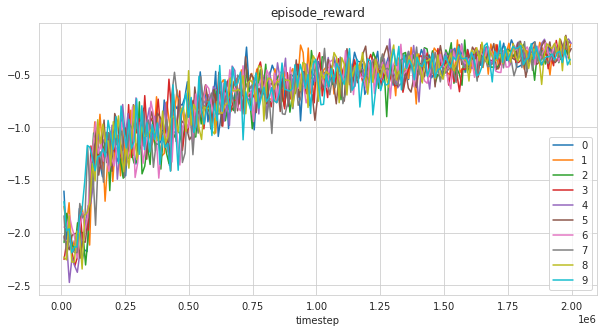

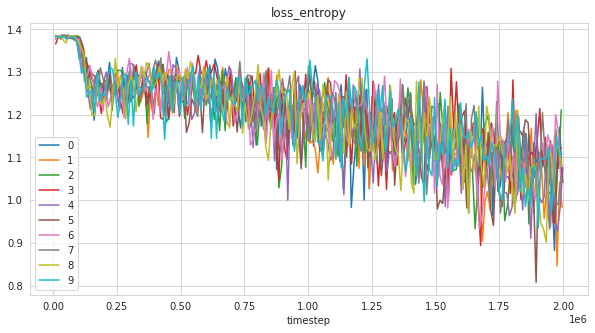

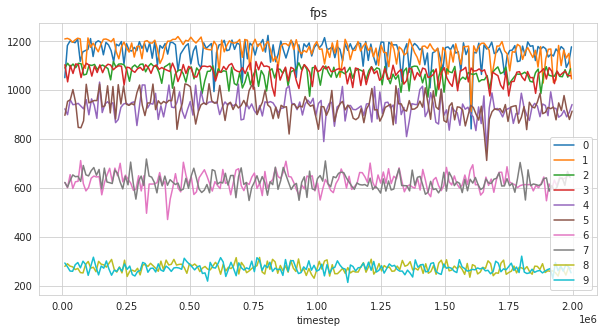

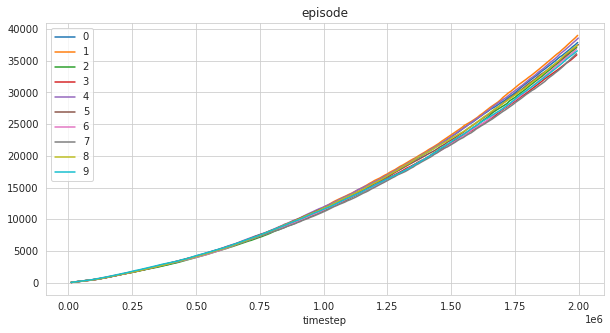

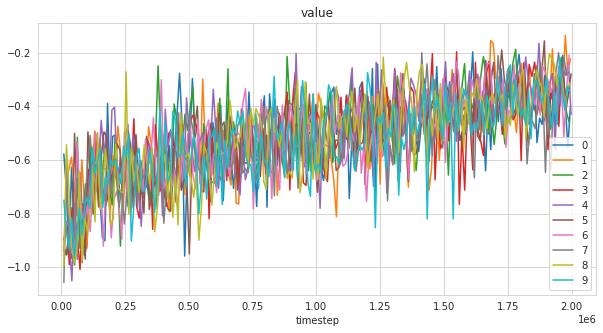

In [80]:
ax = None

target_vars = [
    "episode_reward",
    "loss_entropy",
    "act",
    "fps",
    "episode",
    "value",
]

top_q = 0.0

for target_var in target_vars:
    ax = None
    for key, df in dfs.items():
        if scores[key] < scores.quantile(top_q):
            continue
        if target_var in df.columns:
            df = df.set_index("timestep")[target_var]
            df = df.rolling(1).mean()
            ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
#             ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
            plt.title(target_var)

In [81]:
rows = {}
for key, arg in overrides.items():
    row = {}
    if type(arg) is list:
        for s in arg:
            col, val = s.split("=")
            row[col] = val
        rows[key] = (pd.Series(row))
results = pd.DataFrame(rows)
results = results.append(scores.rename("score"))
results = results.T.sort_values("score", ascending=False)
results

,agent,agent.network_params.architecture,env,agent.network_params.random_cog_fraction,agent.algo_params.update_cognitive_values,score
1,a2c_image,ff,mazelab,0.0,false,-0.669675
4,a2c_image,ff,mazelab,0.2,true,-0.67382
0,a2c_image,ff,mazelab,0.0,true,-0.674618
8,a2c_image,ff,mazelab,0.8,true,-0.683441
9,a2c_image,ff,mazelab,0.8,false,-0.684844
5,a2c_image,ff,mazelab,0.2,false,-0.689182
6,a2c_image,ff,mazelab,0.5,true,-0.695096
3,a2c_image,ff,mazelab,0.05,false,-0.696898
7,a2c_image,ff,mazelab,0.5,false,-0.699995
2,a2c_image,ff,mazelab,0.05,true,-0.7172


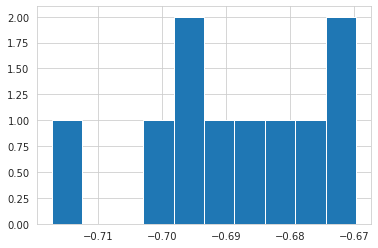

In [82]:
results.score.hist()

In [83]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [84]:
for key, config in configs.items():
    configs[key] = flatten(config)
full_results = pd.DataFrame(configs).append(scores.rename("score")).T.sort_values("score", ascending=False)
full_results

,num_timesteps,device,seed,num_envs,model_params_count,log_timestep_interval,log_save_tb,save_video,eval_timestep_interval,num_eval_episodes,...,agent_algo_params_entropy_coef,agent_algo_params_eps,agent_algo_params_alpha,agent_algo_params_max_grad_norm,agent_algo_params_use_timeout,agent_algo_params_smooth_value_loss,agent_algo_params_reward_rescale,agent_algo_params_update_cognitive_values,agent_algo_params_optimizer_type,score
1,2e+06,cpu,159233795,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,False,rmsprop,-0.669675
4,2e+06,cpu,159234339,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,True,rmsprop,-0.67382
0,2e+06,cpu,159233617,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,True,rmsprop,-0.674618
8,2e+06,cpu,159235402,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,True,rmsprop,-0.683441
9,2e+06,cpu,159236147,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,False,rmsprop,-0.684844
5,2e+06,cpu,159234551,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,False,rmsprop,-0.689182
6,2e+06,cpu,159234763,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,True,rmsprop,-0.695096
3,2e+06,cpu,159234155,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,False,rmsprop,-0.696898
7,2e+06,cpu,159235082,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,False,rmsprop,-0.699995
2,2e+06,cpu,159233971,16,457733,10000,True,True,100000,16,...,0.01,1e-05,0.99,0.1,True,True,False,True,rmsprop,-0.7172
